## Initialization

In [ ]:
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install wfdb

import os
import wfdb
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  project_directory='/content/drive/MyDrive/TKTE/Dataset/'
  os.chdir(project_directory)
except:
  pass

Mounted at /content/drive


## Data Visualization

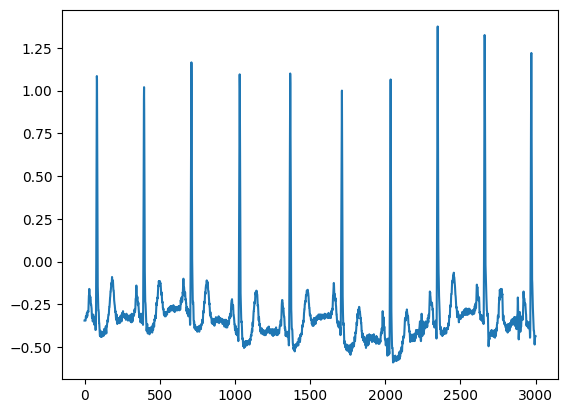

In [ ]:
# Specify the record name and path
record_name = '101'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'

# Read the ECG record. We can optionally pass in the `sampto` parameter to read a specific number of samples. Let's try 3000.
record = wfdb.rdrecord(record_path, sampto=3000)

# Extract the ECG signal from the first lead of the record
ecg_signal = record.p_signal[:,0]

# Plotting the ECG signal
plt.plot(ecg_signal)

## Data Preprocessing

In [ ]:
record_name = '101'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

In [ ]:
peaks = annotation.sample
symbols = annotation.symbol

In [ ]:
print(peaks[:10])
print(symbols[:10])

[   7   83  396  711 1032 1368 1712 2036 2349 2662]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [ ]:
data_path = './mit-bih-arrhythmia-database-1.0.0/'
record_list = wfdb.get_record_list('mitdb')

Data Preprocessing
- Break signal into segments of 10 R-R intervals
- Filter them so that only two classes remain (Normal ECG & Arrhythmic ECG)

- Normal ECG
    - Label = 0
    - All R-R intervals are from normal beats, annotated with 'N'
- Arrhythmic ECG
  - Label = 1
  - At least 2/10 beats are annotated with the 'V' symbol

In [ ]:
X = []  # R-R intervals
Y = []  # labels (normal = 0, arrhythmic = 1)

window_size = 10

for record_name in record_list:
  # Load the signal and annotations
  annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')
  # print("annotation", annotation)

  # Detect peaks
  peaks = annotation.sample
  # print("peaks:",peaks)

  # Get R-R intervals
  intervals = np.diff(peaks)
  # print("intervals:", intervals)

  # Normalize the intervals
  normalized_intervals = intervals / intervals.max()
  # print("normalized_intervals:", normalized_intervals)

  # Break up the intervals into segments of 10
  for i in range(len(intervals) - window_size +1):
    # Get the annotations and intervals for the current window
    window_annotations = annotation.symbol[i:i + window_size]
    window_intervals = normalized_intervals[i:i + window_size]

    # Count of abnormal beats
    abnormal_count = sum(1 for ann in window_annotations if ann == 'V')

    # Select windows that are either all 'N' or have at least 2 'V's
    if all(ann == 'N' for ann in window_annotations) or (abnormal_count >= 2):
      X.append(window_intervals)
      Y.append(abnormal_count >= 2)

In [ ]:
X = np.array(X)
Y = np.array(Y)

## Data Balancing

Text(0, 0.5, 'Count')

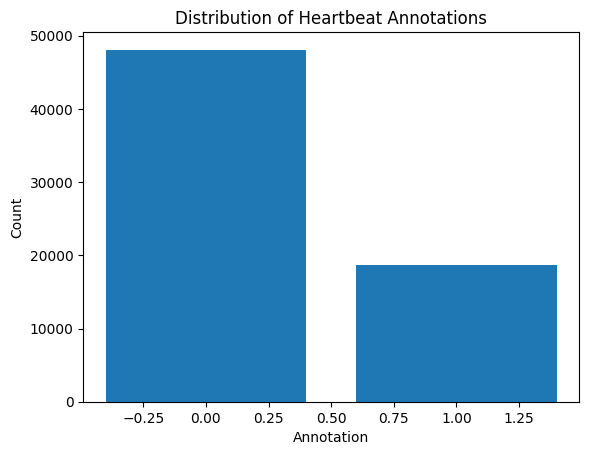

In [ ]:
annotation_counter = Counter()
annotation_counter.update(Y)

plt.bar(annotation_counter.keys(), annotation_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')

Pada data di atas, terlihat data normal heartbeat lebih dari 2x jumlahnya dibanding arrhythmic heartbeat

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X_train)
print(Y_train)
print(len(X_train))
print(len(Y_train))

[[0.61344538 0.37394958 0.63445378 ... 0.34663866 0.56302521 0.56722689]
 [0.58922559 0.45117845 0.53030303 ... 0.46296296 0.34680135 0.55050505]
 [0.57882353 0.54823529 0.55058824 ... 0.45411765 0.6        0.42823529]
 ...
 [0.53164557 0.51424051 0.26424051 ... 0.41139241 0.28164557 0.5585443 ]
 [0.63390663 0.61670762 0.65601966 ... 0.67076167 0.67567568 0.67076167]
 [0.49087894 0.52736318 0.55223881 ... 0.50414594 0.53399668 0.55887231]]
[ True False  True ...  True False False]
53425
53425


38494.0
76988


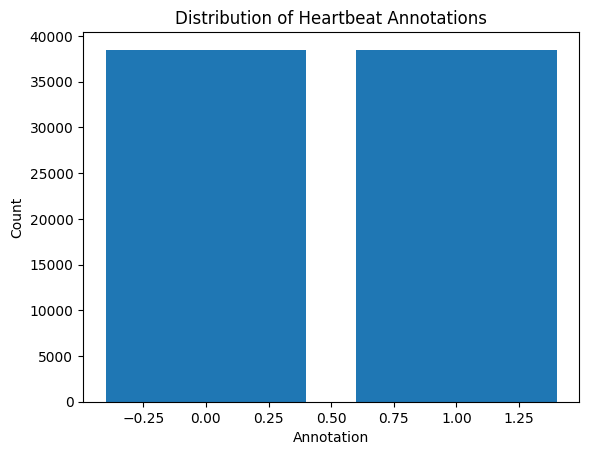

In [ ]:
# Fix class imbalance
smote = SMOTE()

# Fit SMOTE to the training data
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

print(len(X_train_smote)/2)
print(len(Y_train_smote))

annotation_smote_counter = Counter()
annotation_smote_counter.update(Y_train_smote)

plt.bar(annotation_smote_counter.keys(), annotation_smote_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.show()

## Subject Oriented Data Preparation

In [ ]:
# Group data by subject
subject_ids = df['subject_id'].unique()  # Assuming df has a 'subject_id' column
test_subjects = np.random.choice(subject_ids, size=int(0.2 * len(subject_ids)), replace=False)
train_subjects = [s for s in subject_ids if s not in test_subjects]

# Create subject-oriented train-test split
train_data = df[df['subject_id'].isin(train_subjects)]
test_data = df[df['subject_id'].isin(test_subjects)]

X_train_subject = train_data.drop(columns=['label', 'subject_id']).values
Y_train_subject = train_data['label'].values
X_test_subject = test_data.drop(columns=['label', 'subject_id']).values
Y_test_subject = test_data['label'].values

# Fix class imbalance using SMOTE
smote = SMOTE()
X_train_subject_smote, Y_train_subject_smote = smote.fit_resample(X_train_subject, Y_train_subject)

# Check distribution after SMOTE
plt.bar(*zip(*Counter(Y_train_subject_smote).items()))
plt.title('Balanced Data Distribution (Subject-Oriented)')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.show()

NameError: name 'df' is not defined

## DATA BUAT TESTBENCH

In [ ]:
from google.colab import files

# Download the file
# false_count = 0
# for i in range(101,201):
#   single_input = X_test[i]
#   true_label = Y_test[i]
#   # print(single_input)
#   # print(true_label)
#   print("[")
#   for i in range(len(single_input)):
#     if i == len(single_input) - 1:
#         print(f"{single_input[i]}", end="")
#     else:
#         print(f"{single_input[i]},", end="")
#   print("]")
  # prediction = classifier.predict(np.array([single_input]))
  # prediction_label = prediction[0][0] < prediction[0][1]

  # if true_label != prediction_label:
  #   false_count+=1

# print(false_count)

# Open a file in write mode
with open('output_label.txt', 'w') as file:
    # for i in range(0, 5001):
    #     # single_input = X_test[i]
    #     true_label = Y_test[i]

    #     # # Write the opening bracket
    #     # file.write("[")

    #     # # Write each element of single_input, separated by commas
    #     # for j in range(len(single_input)):
    #     #     if j == len(single_input) - 1:
    #     #         file.write(f"{single_input[j]}")
    #     #     else:
    #     #         file.write(f"{single_input[j]},")

    #     # # Write the closing bracket and newline
    #     # file.write("],\n")

    #     file.write(f"{true_label},")

    # Open the file in write mode
    for i in range(0, 5001):
        true_label = Y_test[i]
        # Write the true_label followed by a comma
        file.write(f"{true_label},")

        # Insert a newline after every 50 values
        if (i + 1) % 50 == 0:
            file.write("\n")

# Note: Ensure that Y_test has at least 5001 elements to avoid index errors.


#files.download('output_label.txt')

## Model Training

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# Parameters
input_dim = X_train.shape[1]  # Number of features
latent_dim = 2  # Latent space dimension
intermediate_dim = 92  # Hidden layer size

# Encoder
inputs = Input(shape=(input_dim,), name='input_encoder')
h = Dense(intermediate_dim, activation='relu', name='intermediate_layer')(inputs)  # Using ReLU

z_mean = Dense(latent_dim, name='z_mean')(h)
z_var = Dense(latent_dim, activation='softplus', name='z_var')(h)  # Ensures variance is positive

# Reparameterization trick
def sampling(args):
    z_mean, z_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.sqrt(z_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="sampling_layer")([z_mean, z_var])

# Misalkan Y_train berisi label biner (True/False)
num_classes = 2  # Ubah sesuai dengan jumlah kelas yang Anda miliki
Y_train_encoded = to_categorical(Y_train_smote.astype(int), num_classes=num_classes)
Y_test_encoded = to_categorical(Y_test.astype(int), num_classes=num_classes)

# Classifier
classifier_h = Dense(intermediate_dim, activation='relu', name="hidden_classifier")(z)  # Using ReLU
classifier_output = Dense(2, activation='sigmoid', name="classifier_output")(classifier_h)

classifier = Model(inputs, classifier_output)

# Compile model with Adam
classifier.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Early stopping callback (stop training if val_loss doesn't improve for 5 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the classifier
history = classifier.fit(X_train_smote, Y_train_encoded,
                         epochs=50, batch_size=128,  # Batch size optimized
                         validation_data=(X_test, Y_test_encoded))
                        #  ,callbacks=[early_stopping])

loss, accuracy = classifier.evaluate(X_test, Y_test_encoded)
print(f'Classifier accuracy: {accuracy * 100:.2f}%')

# Update 26 FEB 2025, ganti softplus jadi relu

Epoch 1/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7251 - loss: 0.5121 - val_accuracy: 0.9138 - val_loss: 0.2144
Epoch 2/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9304 - loss: 0.1948 - val_accuracy: 0.9198 - val_loss: 0.1985
Epoch 3/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9368 - loss: 0.1760 - val_accuracy: 0.9294 - val_loss: 0.1716
Epoch 4/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9385 - loss: 0.1718 - val_accuracy: 0.9310 - val_loss: 0.1679
Epoch 5/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9389 - loss: 0.1716 - val_accuracy: 0.9233 - val_loss: 0.1868
Epoch 6/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9392 - loss: 0.1656 - val_accuracy: 0.9192 - val_loss: 0.1960
Epoch 7/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9397 - loss: 0.1669 - val_accuracy: 0.9261 - val_loss: 0.1732
Epoch 8/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9392 - loss: 0.1648 - val_accuracy: 0.

Training with Optuna

In [ ]:
!pip install optuna
import optuna
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Pastikan X_train, X_train_smote, Y_train_smote, X_test, Y_test sudah didefinisikan sebelumnya

def create_model(trial):
    # Hyperparameter dari trial
    latent_dim = trial.suggest_int('latent_dim', 2, 2, step=2)
    intermediate_dim = trial.suggest_int('intermediate_dim', 6, 96, step=2)

    print("Trial config:", latent_dim, intermediate_dim)

    # Encoder
    inputs = Input(shape=(X_train_smote.shape[1],))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    num_classes = 2
    Y_train_encoded = to_categorical(Y_train_smote.astype(int), num_classes=num_classes)
    Y_test_encoded = to_categorical(Y_test.astype(int), num_classes=num_classes)

    # Classifier
    clf_h = Dense(intermediate_dim, activation='relu')(z)
    clf_out = Dense(2, activation='sigmoid')(clf_h)

    model = Model(inputs, clf_out)
    model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Pastikan label sudah one-hot encoded sebelumnya
    return model, Y_train_encoded, Y_test_encoded



def objective(trial):
    model, Y_train_encoded, Y_test_encoded = create_model(trial)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_smote, Y_train_encoded,
              epochs=30, batch_size=128, validation_data=(X_test, Y_test_encoded),
              verbose=0, callbacks=[early_stopping])

    # Prediksi probabilitas & konversi ke label
    Y_pred = model.predict(X_test)
    Y_pred_labels = (Y_pred > 0.5).astype(int)

    # Konversi dari one-hot ke label index
    y_true = np.argmax(Y_test_encoded, axis=1)
    y_pred = np.argmax(Y_pred_labels, axis=1)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Hitung metrik
    accuracy = accuracy_score(Y_test_encoded, Y_pred_labels)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Custom score dengan bobot
    custom_score = 0.4 * accuracy + 0.3 * sensitivity + 0.3 * specificity

    # Optuna meminimalkan, jadi balik tanda
    return custom_score


# 🔧 2. Jalankan Optuna Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Jumlah trial bisa kamu tambah

optuna.visualization.plot_optimization_history(study).show()

# 🔍 3. Print hasil terbaik
print("Best hyperparameters:", study.best_params)
print(f"Best accuracy:{study.best_value:.4f}")


[I 2025-04-22 02:03:34,333] A new study created in memory with name: no-name-922afcec-0b9b-4692-a134-95ebc0e496b9


Trial config: 2 74
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:04:52,434] Trial 0 finished with value: 0.9295578046986401 and parameters: {'latent_dim': 2, 'intermediate_dim': 74}. Best is trial 0 with value: 0.9295578046986401.


Trial config: 2 68
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:06:08,114] Trial 1 finished with value: 0.9331210658686591 and parameters: {'latent_dim': 2, 'intermediate_dim': 68}. Best is trial 1 with value: 0.9331210658686591.


Trial config: 2 74
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-04-22 02:07:05,659] Trial 2 finished with value: 0.9285446017836791 and parameters: {'latent_dim': 2, 'intermediate_dim': 74}. Best is trial 1 with value: 0.9331210658686591.


Trial config: 2 34
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:08:20,872] Trial 3 finished with value: 0.9307899522452058 and parameters: {'latent_dim': 2, 'intermediate_dim': 34}. Best is trial 1 with value: 0.9331210658686591.


Trial config: 2 92
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:09:29,645] Trial 4 finished with value: 0.939450374774694 and parameters: {'latent_dim': 2, 'intermediate_dim': 92}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 42
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:10:39,721] Trial 5 finished with value: 0.9339642514824216 and parameters: {'latent_dim': 2, 'intermediate_dim': 42}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 54
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:11:55,581] Trial 6 finished with value: 0.9334457999966351 and parameters: {'latent_dim': 2, 'intermediate_dim': 54}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 46
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:13:04,404] Trial 7 finished with value: 0.9285886271490068 and parameters: {'latent_dim': 2, 'intermediate_dim': 46}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 72
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:14:02,273] Trial 8 finished with value: 0.9071084542758385 and parameters: {'latent_dim': 2, 'intermediate_dim': 72}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 44
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:15:35,214] Trial 9 finished with value: 0.926665126645928 and parameters: {'latent_dim': 2, 'intermediate_dim': 44}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 94
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:17:13,490] Trial 10 finished with value: 0.9312585534214123 and parameters: {'latent_dim': 2, 'intermediate_dim': 94}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 16
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:18:20,135] Trial 11 finished with value: 0.8880921234296073 and parameters: {'latent_dim': 2, 'intermediate_dim': 16}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 94
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:19:47,431] Trial 12 finished with value: 0.9339311776502199 and parameters: {'latent_dim': 2, 'intermediate_dim': 94}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 24
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:20:57,525] Trial 13 finished with value: 0.9310114901585239 and parameters: {'latent_dim': 2, 'intermediate_dim': 24}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 6
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:22:02,250] Trial 14 finished with value: 0.8756059194300054 and parameters: {'latent_dim': 2, 'intermediate_dim': 6}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 60
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:23:23,399] Trial 15 finished with value: 0.920453917069479 and parameters: {'latent_dim': 2, 'intermediate_dim': 60}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 32
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:24:34,171] Trial 16 finished with value: 0.9247913598726798 and parameters: {'latent_dim': 2, 'intermediate_dim': 32}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 86
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:25:52,774] Trial 17 finished with value: 0.9368572520949033 and parameters: {'latent_dim': 2, 'intermediate_dim': 86}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 86
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:27:09,920] Trial 18 finished with value: 0.9335654087981232 and parameters: {'latent_dim': 2, 'intermediate_dim': 86}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 84
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:28:25,260] Trial 19 finished with value: 0.934584211584294 and parameters: {'latent_dim': 2, 'intermediate_dim': 84}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 84
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:29:37,577] Trial 20 finished with value: 0.9339890885846839 and parameters: {'latent_dim': 2, 'intermediate_dim': 84}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 82
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:31:06,929] Trial 21 finished with value: 0.9371451196178988 and parameters: {'latent_dim': 2, 'intermediate_dim': 82}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 96
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:32:15,207] Trial 22 finished with value: 0.9311793211963257 and parameters: {'latent_dim': 2, 'intermediate_dim': 96}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 82
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:33:31,714] Trial 23 finished with value: 0.9359636157521569 and parameters: {'latent_dim': 2, 'intermediate_dim': 82}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 88
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:35:13,334] Trial 24 finished with value: 0.9340503443920793 and parameters: {'latent_dim': 2, 'intermediate_dim': 88}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 64
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:36:40,420] Trial 25 finished with value: 0.9267584854614832 and parameters: {'latent_dim': 2, 'intermediate_dim': 64}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 78
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-04-22 02:38:17,429] Trial 26 finished with value: 0.9358079721276014 and parameters: {'latent_dim': 2, 'intermediate_dim': 78}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 90
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:39:51,197] Trial 27 finished with value: 0.9376083695814366 and parameters: {'latent_dim': 2, 'intermediate_dim': 90}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 58
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:41:20,942] Trial 28 finished with value: 0.9264538524676755 and parameters: {'latent_dim': 2, 'intermediate_dim': 58}. Best is trial 4 with value: 0.939450374774694.


Trial config: 2 76
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-04-22 02:42:53,794] Trial 29 finished with value: 0.9360712478375186 and parameters: {'latent_dim': 2, 'intermediate_dim': 76}. Best is trial 4 with value: 0.939450374774694.


Best hyperparameters: {'latent_dim': 2, 'intermediate_dim': 92}
Best accuracy:0.9395


In [ ]:
from sklearn.metrics import confusion_matrix

# Get model predictions
Y_pred_probs = classifier.predict(X_test)
Y_pred = (Y_pred_probs[:, 1] > 0.5).astype(int)  # Convert to binary labels

# Convert one-hot encoded Y_test back to labels
Y_test_labels = Y_test_encoded[:, 1].astype(int)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test_labels, Y_pred).ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = (tp / (tp + fn)) * 100  # Recall
specificity = (tn / (tn + fp)) * 100

print(f'Sensitivity (Recall): {sensitivity: .2f}' + '%')
print(f'Specificity: {specificity: .2f}' + '%')

418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Sensitivity (Recall):  95.93%
Specificity:  92.70%


In [ ]:
from google.colab import files
classifier.save("fixed_classifier.h5")
#files.download("fixed_classifier.h5")

In [ ]:
from google.colab import files
classifier.save("fixed_classifier.keras")
#files.download("fixed_classifier.keras")

File .keras atau .h5 taruh di /content/ aja terus bisa diload

In [ ]:
from tensorflow.keras.models import load_model

# classifier = load_model("/content/fixed_classifier.h5")
# classifier = load_model("/content/fixed_classifier.keras")

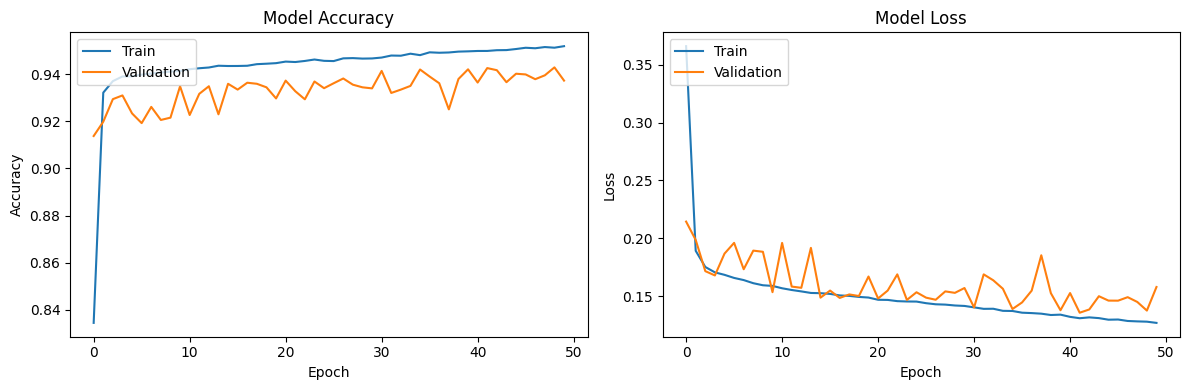

In [ ]:
# Plot training
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Assuming `history` is the result of the `fit` method from training your model
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Example usage
# history = classifier.fit(...)  # Train your model and get the history
plot_training_history(history)


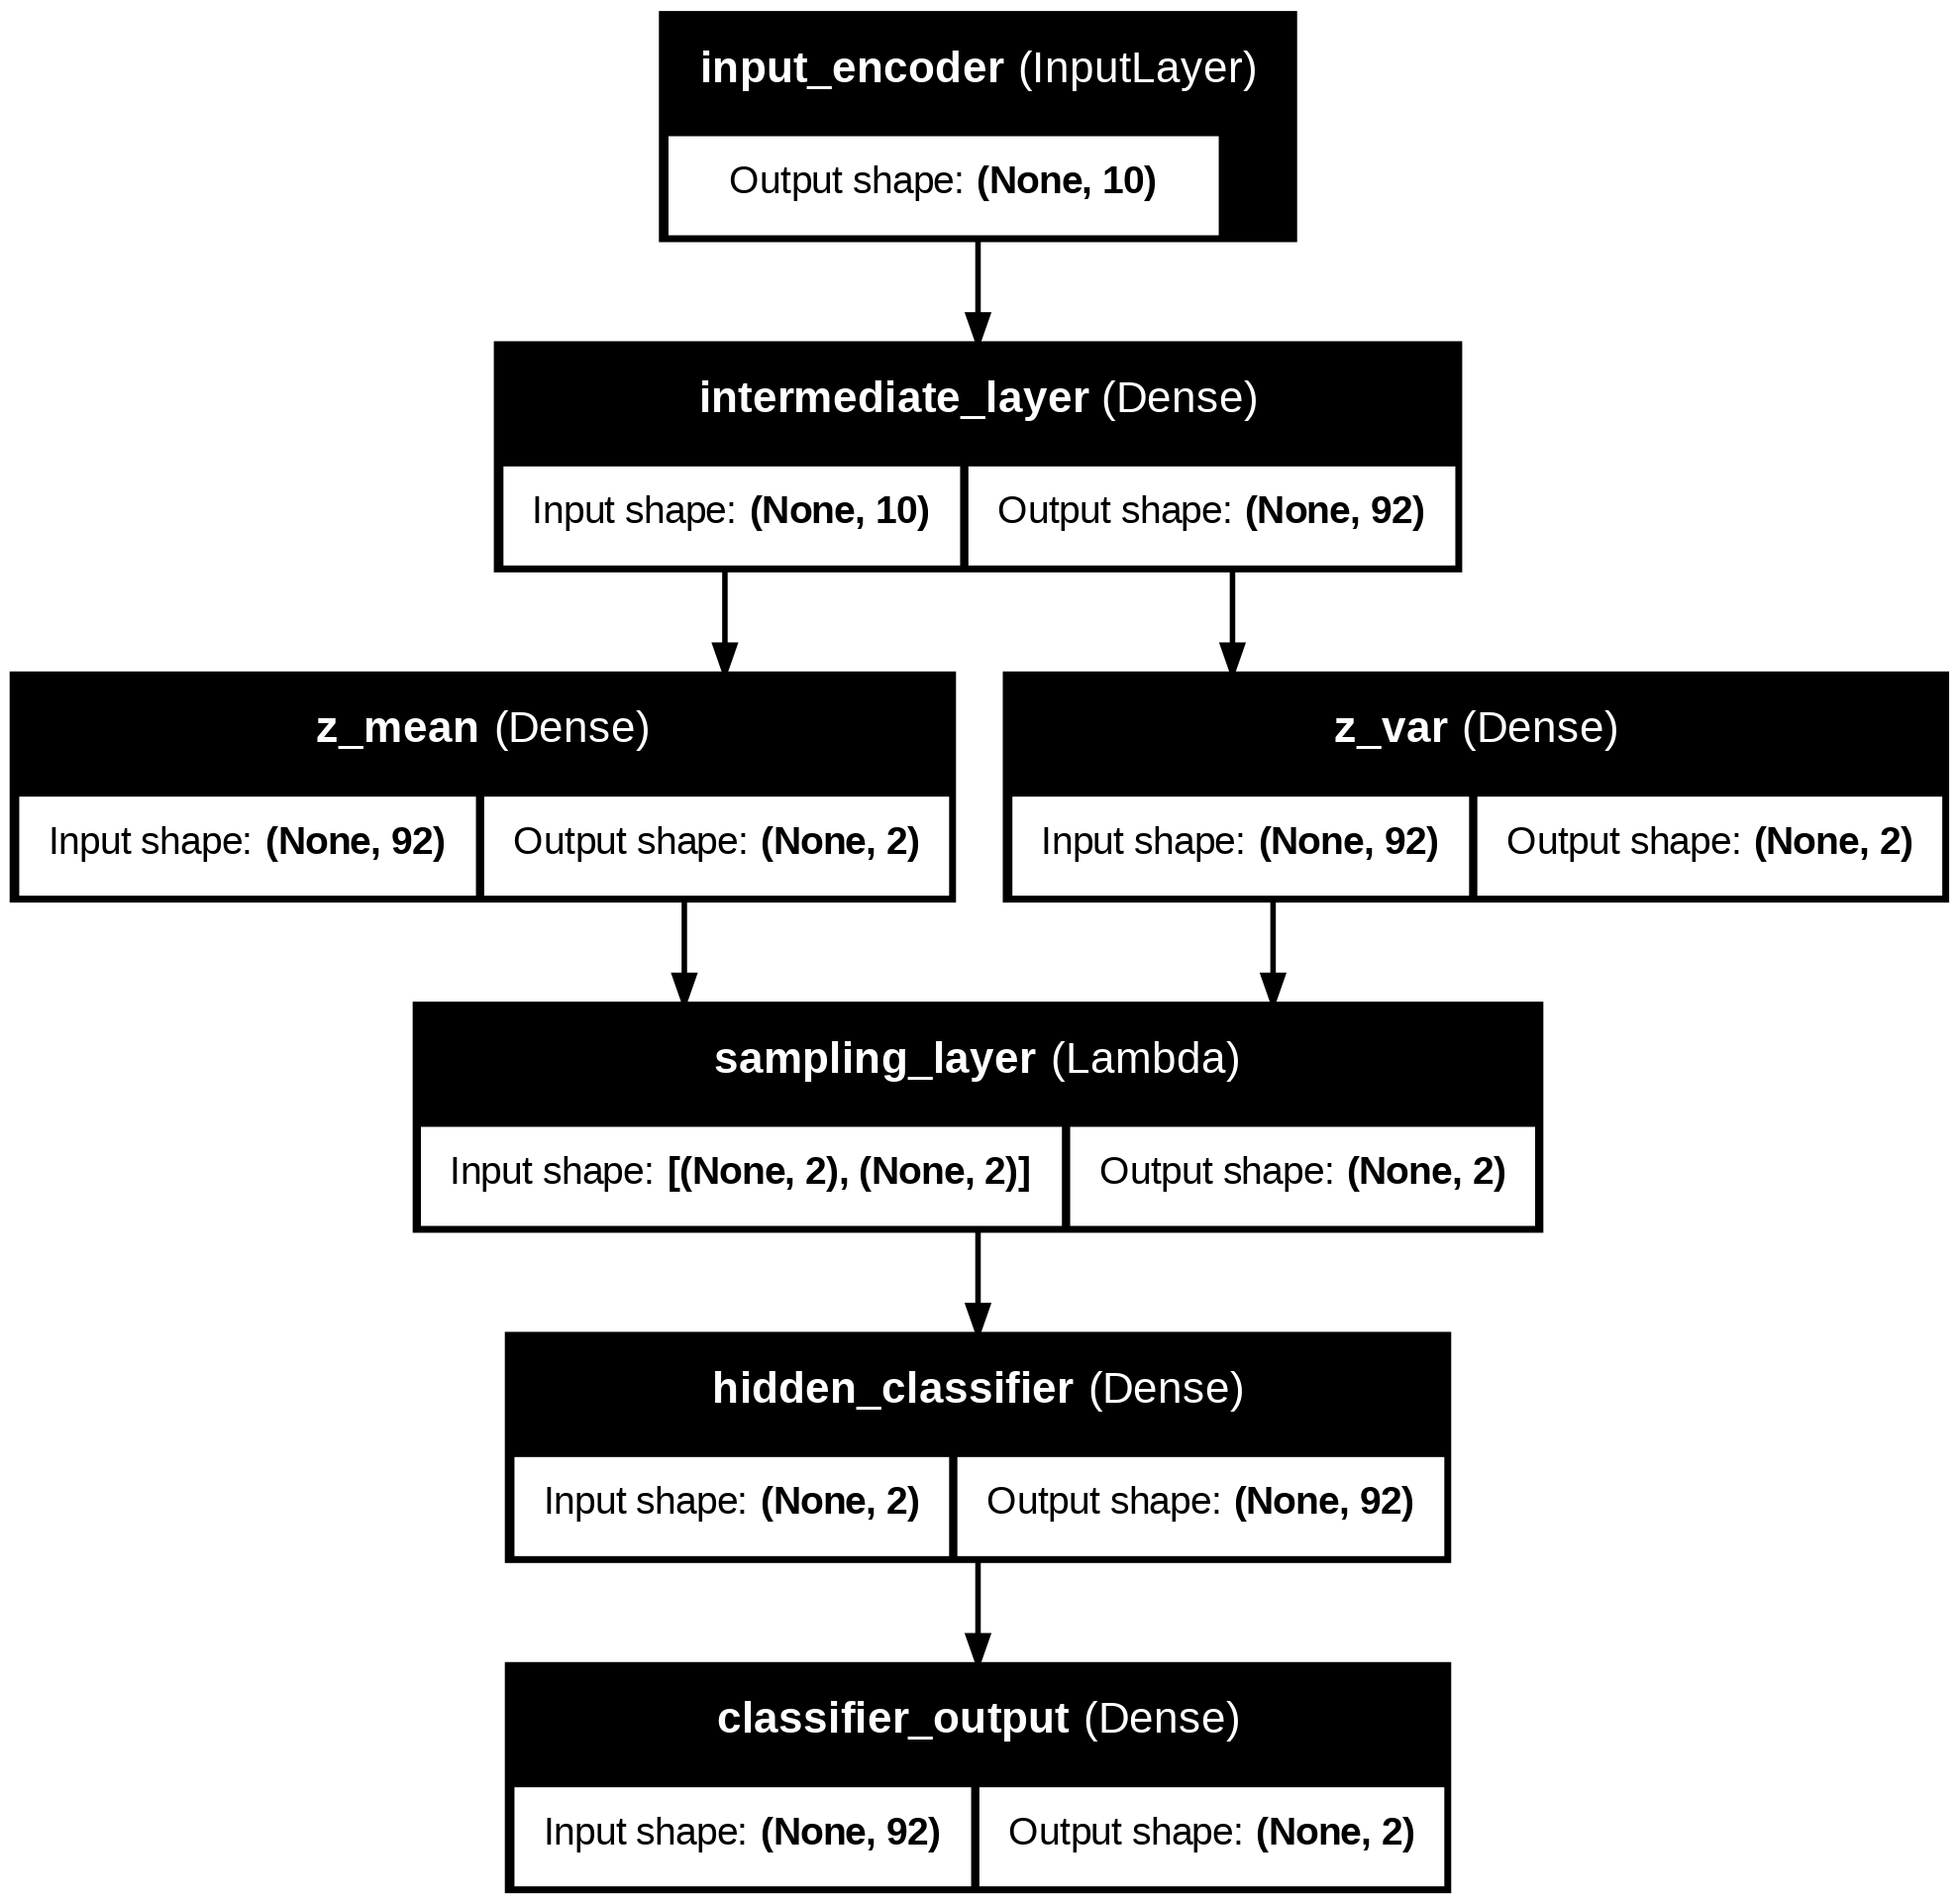

In [ ]:
# Print model pake model baru
# Plot model architecture
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def float_to_custom_binary(float_value):
    # Determine the sign bit
    sign_bit = 0 if float_value >= 0 else 1

    # Get the absolute value of the float for further processing
    abs_value = abs(float_value)

    # Separate the integer and fractional parts
    integer_part = int(abs_value)
    fractional_part = abs_value - integer_part

    # Convert the integer part to binary (4 bits)
    integer_binary = format(integer_part & 0b1111, '04b')

    # Convert the fractional part to binary (11 bits)
    fractional_binary = ''
    for _ in range(11):
        fractional_part *= 2
        bit = int(fractional_part)
        fractional_binary += str(bit)
        fractional_part -= bit

    # Combine all parts into a single binary string
    custom_binary = f"{sign_bit}{integer_binary}{fractional_binary}"
    return custom_binary

In [ ]:
from google.colab import files
import os

def save_model_parameters_per_layer(model):
    saved_files = []

    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) == 2:
            weight_matrix, bias_vector = weights

            layer_name = layer.name

            weight_filename = f"{layer_name}_weights.mem"
            bias_filename = f"{layer_name}_biases.mem"

            # Save weights
            with open(weight_filename, 'w') as wf:
                for row in weight_matrix:
                    for val in row:
                        wf.write(float_to_custom_binary(val) + '\n')
            saved_files.append(weight_filename)

            # Save biases
            with open(bias_filename, 'w') as bf:
                for val in bias_vector:
                    bf.write(float_to_custom_binary(val) + '\n')
            saved_files.append(bias_filename)

        elif len(weights) == 1:
            weight_matrix = weights[0]
            layer_name = layer.name
            weight_filename = f"{layer_name}_weights.mem"

            with open(weight_filename, 'w') as wf:
                for row in weight_matrix:
                    for val in row:
                        wf.write(float_to_custom_binary(val) + '\n')
            saved_files.append(weight_filename)

    # Download all files in Colab
    for filename in saved_files:
        files.download(filename)

In [ ]:
save_model_parameters_per_layer(classifier)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def print_weights_and_biases(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) == 2:
            weights, biases = weights
            print(f"Layer: {layer.name}")
            print(f"Weights: {weights}")
            print(f"Biases: {biases}\n")
        elif len(weights) == 1:
            # Some layers might only have weights but no biases
            weights = weights[0]
            print(f"Layer: {layer.name}")
            print(f"Weights: {weights}\n")
        else:
            # Layers without weights or biases
            print(f"Layer: {layer.name} has no weights or biases.\n")

# Example usage
print_weights_and_biases(classifier)


Layer: input_encoder has no weights or biases.

Layer: intermediate_layer
Weights: [[ 9.04804692e-02  1.15170747e-01  8.93545151e-02 -8.20264280e-01
   3.60393533e-05 -2.54771244e-02 -6.83310091e-01 -1.39318958e-01
   4.23728488e-02 -1.11592123e-02 -6.29497692e-02 -3.40101570e-01
  -1.17927819e-01  1.07717440e-01 -1.17267124e-01  3.07121038e-01
   2.60949373e-01  3.61572444e-01 -2.18254313e-01 -9.05408740e-01
   1.34877533e-01  1.80412903e-01 -2.01936230e-01  4.02197957e-01
  -1.72850147e-01 -5.60991503e-02 -2.34220028e-01  1.33158445e-01
  -3.03891748e-02 -2.69289255e-01  1.01306513e-01 -1.71388939e-01
   3.26783508e-02  9.33860466e-02  1.30683467e-01 -8.49381834e-02
   6.97500557e-02  1.44397110e-01  2.87110284e-02  2.62663007e-01
  -1.02228232e-01  7.68371075e-02 -1.55882895e-01  2.26381168e-01
  -7.59080350e-02  7.90436044e-02  1.44684792e-01  1.01264909e-01
   1.56436116e-01 -2.16875225e-01  1.80373743e-01  1.87515929e-01
  -7.24126548e-02 -1.70938715e-01 -1.29445091e-01 -3.142060

In [ ]:
print(len(Y_test))

13357


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model

# # Define the number of samples to test
# num_samples = 300  # You can adjust this based on dataset size

# # Select random sample indices
# sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

# # Store results for plotting
# latent_values = []
# predictions = []
# true_labels = []

# # Get model layers
# layer_outputs = [layer.output for layer in classifier.layers]  # Get outputs of all layers
# layer_names = [layer.name for layer in classifier.layers]      # Get layer names

# # Iterate over selected test samples
# for sample_index in sample_indices:
#     single_input = X_test[sample_index]
#     true_label = Y_test[sample_index]

#     # Extract latent space and classifier output
#     intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_outputs)
#     intermediate_output = intermediate_layer_model.predict(np.array([single_input]))

#     # Assuming the latent space is from the second-to-last layer
#     latent_space_output = intermediate_output[-2].flatten()  # Modify index based on actual layer structure

#     # Get classifier output (last layer)
#     y1, y2 = intermediate_output[-1].flatten()
#     prediction = y1 > y2  # True if y1 > y2, otherwise False

#     # Store results
#     latent_values.append(latent_space_output)
#     predictions.append(prediction)
#     true_labels.append(np.argmax(true_label))  # Assuming one-hot encoding

# # Convert to numpy arrays for easier processing
# latent_values = np.array(latent_values).flatten()  # Assuming 1D latent space
# predictions = np.array(predictions)
# true_labels = np.array(true_labels)

# # Scatter plot of latent values, colored by true label
# plt.figure(figsize=(10, 4))
# plt.scatter(latent_values, np.zeros_like(latent_values), c=true_labels, cmap="viridis", alpha=0.7)
# plt.xlabel("Latent Space Value")
# plt.title("Latent Space Visualization")
# plt.colorbar(label="True Class Label")
# plt.show()

# # Histogram of latent space distribution
# plt.figure(figsize=(8, 4))
# plt.hist(latent_values, bins=30, alpha=0.7, color="blue", edgecolor="black")
# plt.xlabel("Latent Space Value")
# plt.ylabel("Frequency")
# plt.title("Latent Space Distribution")
# plt.show()


In [ ]:
# Output tiap layer

from tensorflow.keras.models import Model
import numpy as np

sample_index = 1  # You can change this to any valid index in the test set

# Get the single input and true label
single_input = X_test[sample_index]
true_label = Y_test[sample_index]
print("input:", single_input, "Label:", true_label)

# Misalkan 'classifier' adalah model Anda
layer_outputs = [layer.output for layer in classifier.layers]  # Dapatkan output dari setiap layer
layer_names = [layer.name for layer in classifier.layers]      # Dapatkan nama dari setiap layer

# Buat model untuk mendapatkan output dari setiap layer
for layer_name, layer_output in zip(layer_names, layer_outputs):
    intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_output)
    intermediate_output = intermediate_layer_model.predict(np.array([single_input]))
    print(f"Output dari layer {layer_name}: {intermediate_output}")


input: [0.55555556 0.46296296 0.41077441 0.42760943 0.33501684 0.57575758
 0.33164983 0.52356902 0.44949495 0.42760943] Label: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Output dari layer input_encoder: [[0.5555556  0.46296296 0.4107744  0.4276094  0.33501685 0.57575756
  0.33164984 0.52356905 0.44949496 0.4276094 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Output dari layer intermediate_layer: [[0.22744355 0.01169859 0.         0.1726548  2.2225344  0.
  0.         0.         0.         0.         0.         2.066872  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Output dari layer z_mean: [[-0.03850436  1.8201119   0.49569058  0.6160989 ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Output dari layer z_var: [[3.88106230e-07 8.29827854e-07 9.15207243e-10 1.07875934e-07]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Output dari layer sampling_layer: [[-0.03757938  1.819806    0.49570626  0.6165501 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Output dari layer hidden_classifier: [[0.793083   0.         1.0370274  0.         0.94056857 1.4219415
  1.9260086  0.         0.09784377 0.06718099 0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Output dari layer classifier_output: [[0.2989692 0.6830809]]


In [ ]:
from tensorflow.keras.models import Model
import numpy as np
from google.colab import files

# Path file output
output_file = "layer_outputs.txt"

# Buka file untuk menulis output
with open(output_file, "w") as f:
    for sample_index in range(0, 51):
        # Get the single input and true label
        single_input = X_test[sample_index]
        true_label = Y_test[sample_index]
        f.write(f"Sample {sample_index} - Label: {true_label}\n")
        f.write(f"Input: {single_input}\n\n")

        # Misalkan 'classifier' adalah model Anda
        layer_outputs = [layer.output for layer in classifier.layers]  # Dapatkan output dari setiap layer
        layer_names = [layer.name for layer in classifier.layers]      # Dapatkan nama dari setiap layer

        # Buat model untuk mendapatkan output dari setiap layer
        for layer_name, layer_output in zip(layer_names, layer_outputs):
            intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_output)
            intermediate_output = intermediate_layer_model.predict(np.array([single_input]))
            f.write(f"Output dari layer {layer_name}: {intermediate_output}\n\n")

print(f"Output telah disimpan di {output_file}")

files.download("layer_outputs.txt")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Range output tiap layer
from tensorflow.keras.models import Model
import numpy as np

# Misalkan 'classifier' adalah model Anda
layer_outputs = [layer.output for layer in classifier.layers]  # Dapatkan output dari setiap layer
layer_names = [layer.name for layer in classifier.layers]      # Dapatkan nama dari setiap layer

# Inisialisasi variabel untuk menyimpan nilai max dan min global
global_max_values = {name: -np.inf for name in layer_names}
global_min_values = {name: np.inf for name in layer_names}

# Loop melalui semua sample index
for sample_index in range(20):
    single_input = X_test[sample_index]

    for layer_name, layer_output in zip(layer_names, layer_outputs):
        intermediate_layer_model = Model(inputs=classifier.input, outputs=layer_output)
        intermediate_output = intermediate_layer_model.predict(np.array([single_input]))

        # Cari nilai terbesar dan terkecil untuk sample ini
        max_value = np.max(intermediate_output)
        min_value = np.min(intermediate_output)

        # Update nilai max dan min global
        if max_value > global_max_values[layer_name]:
            global_max_values[layer_name] = max_value
        if min_value < global_min_values[layer_name]:
            global_min_values[layer_name] = min_value

# Cetak nilai max dan min global untuk setiap layer
for layer_name in layer_names:
    print(f"Layer {layer_name}:")
    print(f"Nilai terbesar global: {global_max_values[layer_name]}")
    print(f"Nilai terkecil global: {global_min_values[layer_name]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━

In [ ]:
# Testing input
import numpy as np

sample_index = 9 # You can change this to any valid index in the test set

# Get the single input and true label
single_input = X_test[sample_index]
true_label = Y_test[sample_index]

# Print the true label
print(f'Single input for the selected sample: {single_input}')
print(f'True label for the selected sample: {true_label}')

# Assuming X_test is your test data
def test_single_input(model, input_data):
    # Reshape input_data if needed, e.g., input_data = input_data.reshape(1, -1)
    prediction = model.predict(np.array([input_data]))
    print(f"Input: {input_data}")
    print(f"Predicted Output: {prediction[0][0] < prediction[0][1]}")

# Example usage
test_single_input(classifier, X_test[sample_index])


Single input for the selected sample: [0.75776398 0.73913043 0.72049689 0.77329193 0.76397516 0.7484472
 0.72981366 0.7484472  0.73602484 0.75776398]
True label for the selected sample: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Input: [0.75776398 0.73913043 0.72049689 0.77329193 0.76397516 0.7484472
 0.72981366 0.7484472  0.73602484 0.75776398]
Predicted Output: False


In [ ]:
false_count = 0
true_count = 0
for i in range(10,21):
  single_input = X_test[i]
  true_label = Y_test[i]
  prediction = classifier.predict(np.array([single_input]))
  prediction_label = prediction[0][0] < prediction[0][1]

  if true_label != prediction_label:
    false_count +=1
    # print(i)
  else:
    true_count +=1


print("false_count",false_count)
print("true_count",true_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
false_count 1
true_count 10


In [ ]:
# # Kode jadul
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Lambda, Layer
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import mse
# from tensorflow.keras import backend as K

# # Parameters
# input_dim = window_size  # Set this to your input dimension
# latent_dim = 2  # Dimension of the latent space
# intermediate_dim_1 = 16
# intermediate_dim_2 = 8

# # Encoder
# inputs = Input(shape=(input_dim,))
# h1 = Dense(intermediate_dim_1, activation='relu')(inputs)
# h2 = Dense(intermediate_dim_2, activation='relu')(h1)
# z_mean = Dense(latent_dim)(h2)
# z_log_var = Dense(latent_dim)(h2)

# # Reparameterization trick
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# # Decoder
# decoder_h1 = Dense(intermediate_dim_2, activation='relu')
# decoder_h2 = Dense(intermediate_dim_1, activation='relu')
# decoder_mean = Dense(input_dim, activation='sigmoid')  # Use 'sigmoid' if input is normalized [0, 1]

# h_decoded1 = decoder_h1(z)
# h_decoded2 = decoder_h2(h_decoded1)
# x_decoded_mean = decoder_mean(h_decoded2)

# # VAE model
# vae = Model(inputs, x_decoded_mean)

# # Custom loss layer
# class VAELossLayer(Layer):
#     def __init__(self, **kwargs):
#         super(VAELossLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         reconstruction_loss = mse(x, x_decoded_mean) * input_dim
#         kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         self.add_loss(K.mean(reconstruction_loss + kl_loss))
#         return x

# # Apply custom loss layer
# outputs = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])

# # Final VAE model with custom loss
# vae = Model(inputs, outputs)
# vae.compile(optimizer='adam')

# # To train the model, use:
# # vae.fit(x_train, x_train, epochs=50, batch_size=128)


In [ ]:
# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# # Train the model
# # history = model.fit(
# #     X_train_smote,
# #     Y_train_smote,
# #     epochs=5,
# #     batch_size=32,
# #     validation_split=0.2,
# #     verbose=1
# # )
# # history = vae.fit(X_train_smote,
# #     Y_train_smote,
# #     epochs=50,
# #     batch_size=128,
# #     validation_split=0.2,
# #     verbose=1)

# history = vae.fit(X_train, X_train,  # For VAE, input and output are the same
#                   epochs=50,
#                   batch_size=128,
#                   validation_data=(X_test, X_test))


In [ ]:
# # plt.plot(history.history['accuracy'], label='Training accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# # plt.title('Training and Validation Accuracy')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()
# # plt.show()

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# Evaluate the model and print the accuracy
# loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
# print(f'Test accuracy: {accuracy}')
# print(f'Loss: {loss}')

## Exporting the Model

In [ ]:
# # Convert the model to the TensorFlow Lite format without quantization
# # converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_keras_model(vae)
# tflite_model = converter.convert()

# # Save the module to a file
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
# !apt-get -qq install xxd
# !xxd -i model.tflite > model.cpp
# !cat model.cpp

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(vae, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# # Example: Print weights and biases for all layers
# # for i, layer in enumerate(model.layers):
# for i, layer in enumerate(vae.layers):
#     print(f"Layer {i + 1}: {layer.name}")
#     weights = layer.get_weights()  # Returns weights and biases as a list
#     if weights:  # Some layers may not have weights (e.g., activation layers)
#         print(f"  Weights: {weights[0].shape}\n{weights[0]}")  # Weight matrix
#         print(f"  Biases: {weights[1].shape}\n{weights[1]}")  # Bias vector
#     else:
#         print("  No weights or biases for this layer.")
#     print()

In [ ]:
# # Test kode
# import numpy as np

# # Select a sample index from the test set
# sample_index = 2  # You can change this to any valid index in the test set

# # Get the single input and true label
# single_input = X_test[sample_index]
# true_label = Y_test[sample_index]

# # Print the true label
# print(f'Single input for the selected sample: {single_input}')
# print(f'True label for the selected sample: {true_label}')

# # Reshape the input to include the batch dimension
# single_input = single_input.reshape(1, -1)  # Shape becomes (1, input_dim)

# # Use the model to predict
# prediction = vae.predict(single_input)

# # Print the prediction
# print(f'Prediction for the selected sample: {prediction}')

# # Assuming binary classification
# threshold = 0.5
# predicted_label = (prediction > threshold).astype(int)

# print(f'Predicted label for the selected sample: {predicted_label[0][0]}')
